# Computer Vision Project

## Initialization

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Load labels data

labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Load photos

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
)

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


## EDA

In [4]:
# Examine the labels dataframe

display(labels.info())
display(labels.describe())
labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


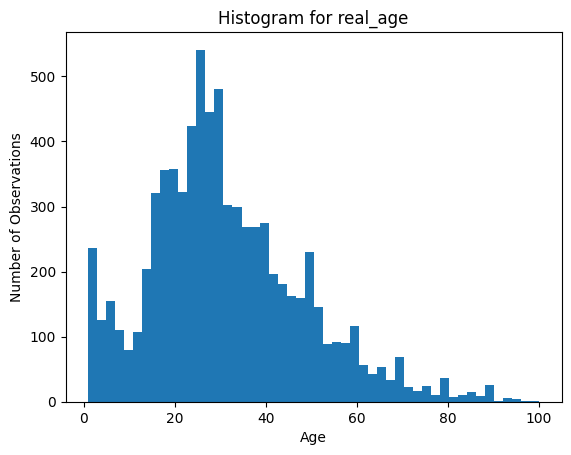

In [5]:
# Plot the distribution of real_age

plt.hist(labels['real_age'], bins=50)
plt.xlabel('Age')
plt.ylabel('Number of Observations')
plt.title(f'Histogram for real_age')
plt.show()

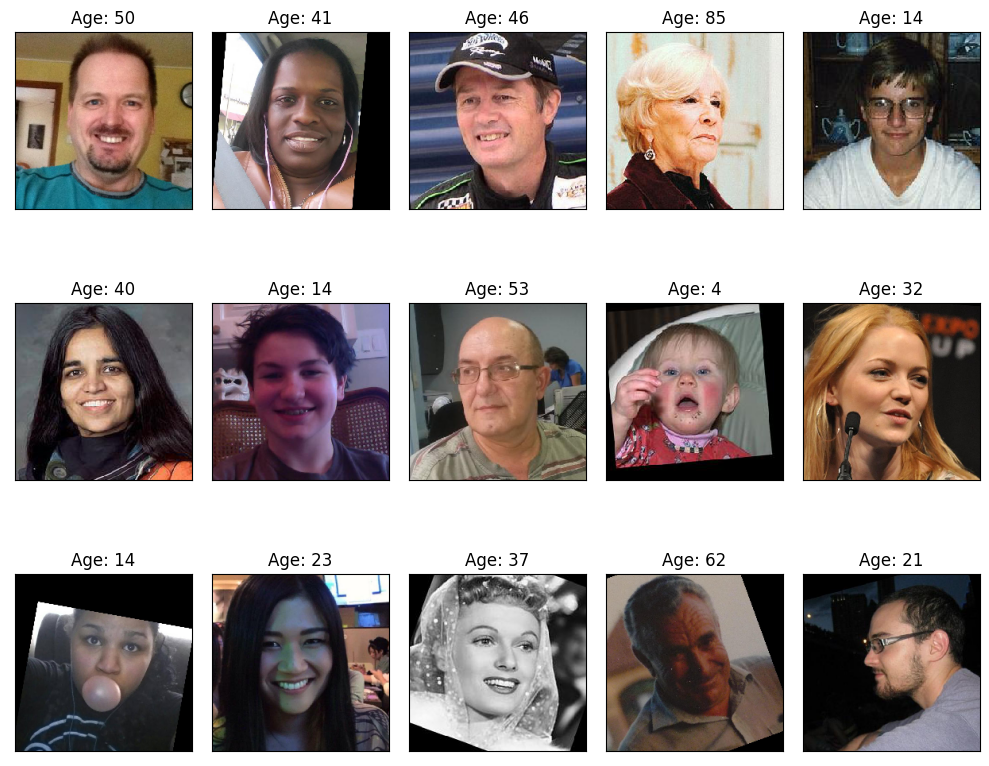

In [6]:
# Print 15 photos

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(f"Age: {target[i]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

The data look good overall. A total of 7,591 photos and labels were loaded, the full set from ChaLearn. The labels file contained no missing or inappropriate values. Ages ranged from 1 to 100 with a mean of 31 and a median of 29. The distribution was relatively normal but moderately right-skewed with an unexpected abundance of one year-olds. Although the threshold of 21 years lies below the mean and mode, it remains firmly within the central bulk of the distribution, ensuring ample training data relevant for distinguishing among borderline cases. 

The image generator selected a random sample, of which I printed 15 photos, ranging in age from 4 to 85. They showed a good diversity of age, sex, race, pose, clothing, lighting, etc.

Based on the age distribution and a sample of photos, I think this dataset is perfectly appropriate for the goal of predicting age and distinguishing minors from adults. However, I do have some concerns about applying such a model to supermarket checkout cameras. The image quality in the training set is varied, ranging from grainy selfies to professional photography to clips from Hollywood films, but it is generally quite high. If Good Seed is using standard-issue security cameras, the image quality will almost certainly be much worse than in the training set. I have low confidence that a model trained on the ChaLearn data will generalize well to security camera footage. 

Good Seed will need to use relatively high-definition cameras and provide adequate lighting in the checkout aisles for this project to be viable. It will also need to incorporate actual photos from its stores into model training, at least to some extent. A hybrid model first trained on the ChaLearn dataset and then fine-tuned with a smaller set of photos taken on site in realistic conditions should suffice. It would entail training the full ResNet model on ChaLearn data and freezing most of the base while training the head on custom photos.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
)

    return train_gen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
)

    return test_gen_flow

In [10]:
def create_model(input_shape):
    
    """
    It defines model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

main_block = """
if __name__ == "__main__":
    train_data = load_train('/datasets/faces')
    test_data = load_test('/datasets/faces')
    model = create_model((224, 224, 3))
    model = train_model(model, train_data, test_data)
    loss, mae = model.evaluate(test_data, verbose=2)
    print(f"Mean Absolute Error: {mae:.2f}")
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
    
    f.write(main_block)
    f.write('\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

```
Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512
```

The model looks decent. Its training loss function and mean absolute error declined consistently, though they tapered off after around Epoch 10, suggesting diminishing returns. The validation loss and MAE dropped until Epoch 8 (val_mae = 6.72) before plateauing. A sharp spike at Epoch 12 (val_mae = 11.46) appears to be an outlier because performance quickly recovered. Validation metrics remained steady until their minimum at Epoch 17 (val_mae = 6.64), after which they rebounded somewhat through Epoch 20 (val_mae = 7.65). The training MAE continued to decline while the validation MAE rebounded, which indicates mild overfitting. Progress on validation MAE was minimal after Epoch 8 and the rebound after Epoch 17 was substantial, nearly cutting in half the gains made up to that point. This model was probably trained for a bit too long. I would either pare epochs back to around 10 or implement early stopping to lock in optimal generalization. Even with the current model trained to Epoch 20, performance was adequate. 

The modeling worked, but evaluating the practical value of the final model is tricky. With an MAE between 6.64 and 7.65, predictions were around 7 years off on average. That means a 21-year-old would likely be labeled somewhere between 14 and 28, which seems like a large margin of error. I cannot be more specific without information about the distribution of errors. If errors lie on a roughly normal distribution, with smaller errors near the central tendency than at the extremes, the MAE likely understates model accuracy for people around the 21-year threshold. Either way, simply cutting off people with predicted ages below 21 would not be an effective way to enforce underage drinking laws. Shifting the threshold to 28 years should exclude most underage people, but precision would probably still be quite poor. A more conservative threshold would be needed, which would reduce the practical utility of the model. The appropriate threshold could be determined by analyzing false positive rates with PR or ROC curves. Everyone below the threshold would need to have their ages manually checked at the point of sale. 

There may be advantages to training a regression model and using it to classify people as underage or adult, especially if there are other uses for granular age predictions, but another option is to train a classifier model directly for the binary outcome of interest. The model might be more accurate because it would focus specifically on information that best demarcates people above and below age 21 instead of trying to balance accuracy across the full lifespan. Classifiers can be tuned to penalize false positives, which in this case violate the law, more than false negatives, which are a waste of time at worst. Choosing the threshold that optimally balances those considerations would be part of the training process. Classifiers also produce probability estimates, which could be helpful for suggesting manual age checks when the model is uncertain. If this model is only going to be used for policing alcohol purchases, I recommend training it as a classifier from the beginning.

## Conclusions

The purpose of this project was to develop a computer vision model that could help the Good Seed supermarket chain avoid selling alcohol to underage people. 

The model was trained on 7.5 thousand images from the ChaLearn face dataset, which contained an appropriately diverse set of photos ranging in age from 1 to 100 with a mean of 31. I evaluated a relatively simple model with a ResNet50 backbone, global average pooling, and a single dense regression layer. It performed well overall. The training metrics decreased consistently over 20 epochs and the validation metrics decreased for about half of the epochs before plateauing and rebounding toward the end. The final model showed signs of overfitting and should probably be trained with fewer epochs or early stopping. The best Mean Absolute Error obtained was 6.64 years and the final score was 7.65 years. 

Although the model improved over the course of training and performed adequately, its practical value was unclear. With the goal of accurately determining whether someone is at least 21 years old, a margin of error around 7 years is awfully high. Implementing a simple threshold of 21 years for alcohol purchases would lead to many violations of the law. Examining the distribution of errors and plotting false positive rates could shift the threshold to help reduce legal violations, but it would need to be quite high (likely greater than 28) to prevent most underage purchases. The age of customers who appear younger would need to be manually checked. Even if the threshold were 30 or 35, significant time and effort could be saved by avoiding manual age checks for anyone older. That said, this model cannot provide a simple, foolproof way to guarantee automated compliance with the law. Its value as a tool must be balanced with equipment and implementation costs. 

I think it would make more sense to train a model devoted specifically to classifying adults older than 21 years old. A binary classification task is more directly applicable to Good Seed's goals and can be better tuned to avoid breaking the law. Classifiers can be trained to avoid costly false positives (apparent adults who are underage) and they offer probability estimates that could be used to trigger manual age checks. Either way, neither a regression nor a classification model is likely to perform as well with supermarket camera photos as it does on the ChaLearn dataset. Good Seed will probably need to invest in high-fidelity cameras and upgraded lighting in any participating store. The model should also be trained at least in part on photos taken in realistic conditions at the stores. Practical performance could be substantially improved by using even a few hundred manually labeled photos to fine-tune part of a model pretrained on ChaLearn data.

The regression model might be worth retaining for other applications. It could as easily enforce age-based restrictions on tobacco, lottery tickets, medicine, and other items as on alcohol. It could also automatically offer senior or student discounts. Going even further, the model could suggest promotions or products based on age, either in person or as coupons embedded in receipts. Such recommendations could be derived or at least improved by integrating purchase data with model-based age estimates. Those data could also be invaluable for customizing each store's ordering, stocking, and marketing decisions based on demographics. It is important to consider potential legal issues with any computer vision application. Privacy must be maintained when storing and processing personal information and images. Care should also be taken to avoid discrimination by ensuring models perform comparably for people with different skin tones, facial features, makeup, clothing, etc. 

I believe that computer vision can help Good Seed in several ways. With the right equipment, specification, and training data, a model much like the one in this project can help avoid selling alcohol to underage customers, even if it cannot offer a comprehensive or foolproof solution. Such a model probably cannot replace manual age verification entirely, but it can significantly reduce it. The value of that help must be weighed against the cost of upgrading equipment, training the model, and implementing it widely. The potential for enforcing other laws, offering relevant promotions, and collecting demographic data might help further offset costs. I cannot definitively determine if that investment is worthwhile without more information, but I tentatively recommend that Good Seed continue to explore computer vision. 

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training